In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Veriyi yükle
reddit_data = pd.read_csv('./Reddit_Data.csv')
twitter_data = pd.read_csv('./Twitter_Data.csv')  # Twitter verilerini yükle

# Boş değerler varsa temizle
reddit_data.dropna(inplace=True)
twitter_data.dropna(inplace=True)

# LabelEncoder ile etiketleri dönüştür
encoder = LabelEncoder()
Y_train = encoder.fit_transform(twitter_data['category'])
Y_test = encoder.transform(reddit_data['category'])

# Keras için one-hot encoding uygula
Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)

# Reddit verileri için tokenizer'ı başlat
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(twitter_data['clean_text'].values)
X_train = tokenizer.texts_to_sequences(twitter_data['clean_text'].values)
X_train = pad_sequences(X_train, maxlen=100)

# Twitter verilerini aynı tokenizer ile işle
X_test = tokenizer.texts_to_sequences(reddit_data['clean_comment'].values)
X_test = pad_sequences(X_test, maxlen=100)

# LSTM modelini oluştur
model = Sequential()
model.add(Embedding(5000, 256))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(256, dropout=0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modeli eğit
batch_size = 512
history=model.fit(X_train, Y_train, epochs=5, batch_size=batch_size, verbose=1)

Epoch 1/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 216s 675ms/step - accuracy: 0.7174 - loss: 0.6481
Epoch 2/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 219s 687ms/step - accuracy: 0.9437 - loss: 0.2017
Epoch 3/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 221s 693ms/step - accuracy: 0.9527 - loss: 0.1740
Epoch 4/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 220s 689ms/step - accuracy: 0.9591 - loss: 0.1516
Epoch 5/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - accuracy: 0.9625 - loss: 0.1391


KeyError: 'val_accuracy'

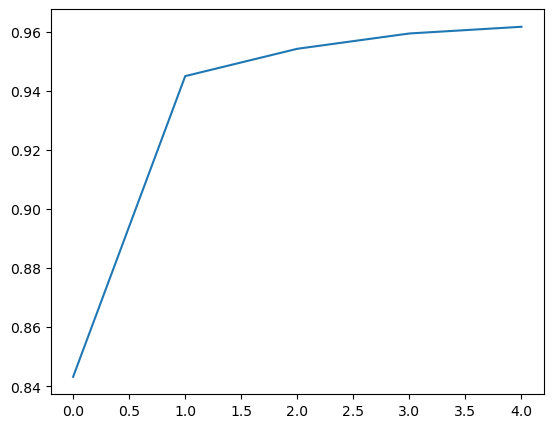

In [25]:
import matplotlib.pyplot as plt

# Eğitim sürecini görselleştir
plt.figure(figsize=(14, 5))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
def predict_sentiment(text):
    # Process the text
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100)
    
    # Get prediction from the model
    pred = model.predict(padded)
    
    # Find the label with the highest probability
    label_index = pred.argmax()
    label = encoder.inverse_transform([label_index])[0]  # Find sentiment label using label encoding
    sentiment_labels = {
        -1: 'Negative',
        0: 'Neutral',
        1: 'Positive'
    }  # Map -1, 0, 1 to labels
    return sentiment_labels[label]

# Örnek bir metin verelim ve tahmin alalım
positive_text = "This was an amazing experience! I truly enjoyed it and would highly recommend everyone to try this activity."
negative_text="Unfortunately, my experience wasn't very pleasant. The event was poorly organized."
neutral_text="The event was quite standard."

sentiment_positive = predict_sentiment(positive_text)
sentiment_negative = predict_sentiment(negative_text)
sentiment_neutral = predict_sentiment(neutral_text)

print(f"The sentiment of the positive_text is positive_text: {sentiment_positive}")
print(f"The sentiment of the negative_text is negative_text: {sentiment_negative}")
print(f"The sentiment of the neutral_text is: {sentiment_neutral}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The sentiment of the positive_text is positive_text: Positive
The sentiment of the negative_text is negative_text: Negative
The sentiment of the neutral_text is: Neutral


In [15]:
# TRAINED MODEL TEST
from sklearn.metrics import classification_report, f1_score

# Modelin performansını değerlendir
loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"Twitter Verileri Üzerinde LSTM Model Doğruluğu: {accuracy}")

# F1 skorunu hesapla
Y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
Y_pred_classes = Y_pred.argmax(axis=1)
Y_test_classes = Y_test.argmax(axis=1)

f1 = f1_score(Y_test_classes, Y_pred_classes, average='weighted')
print(f"Twitter Verileri Üzerinde LSTM Model F1 Skoru: {f1}")

# Daha detaylı bir sınıflandırma raporu
report = classification_report(Y_test_classes, Y_pred_classes, target_names=encoder.classes_)
print(report)

1161/1161 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - accuracy: 0.9368 - loss: 0.2436
Twitter Verileri Üzerinde LSTM Model Doğruluğu: 0.9371988773345947
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 334ms/step
Twitter Verileri Üzerinde LSTM Model F1 Skoru: 0.9363393611607234


TypeError: object of type 'numpy.float64' has no len()

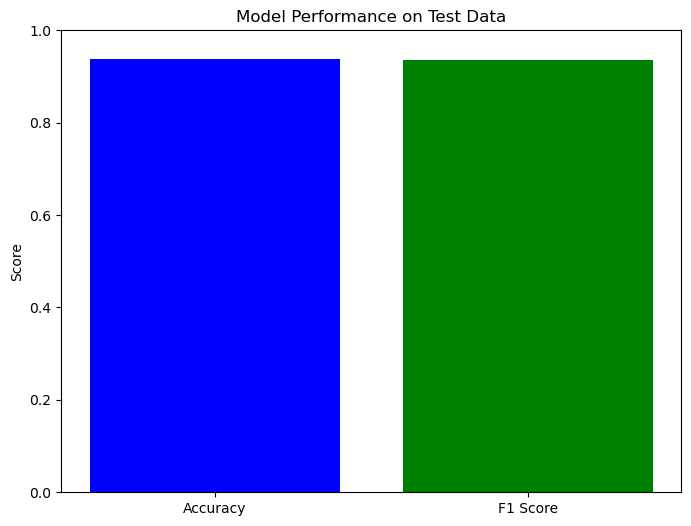

In [19]:
import matplotlib.pyplot as plt

# Doğruluk ve F1 skorunu görselleştirmek için bir çubuk grafiği çiz
metrics = ['Accuracy', 'F1 Score']
values = [accuracy, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green'])
plt.ylim(0, 1)  # Y ekseni sınırlarını 0 ile 1 arasında ayarla
plt.ylabel('Score')
plt.title('Model Performance on Test Data')
plt.show()

TypeError: 'History' object is not subscriptable

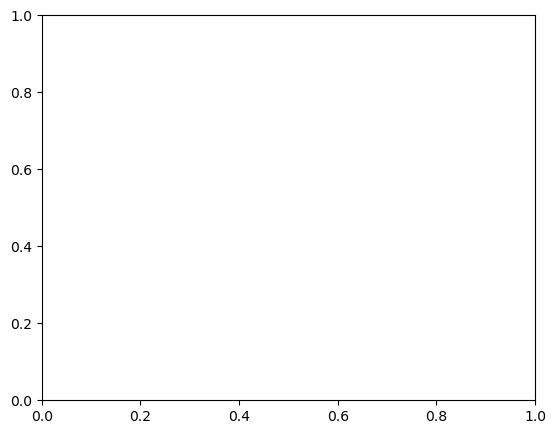

In [21]:
# Eğitim sürecini görselleştir
plt.figure(figsize=(14, 5))
history=model
# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [7]:
model.save('SENTIMENTAL_LSTM.keras')
print("Model SavedModel formatında başarıyla kaydedildi.")

Model SavedModel formatında başarıyla kaydedildi.


In [9]:
import joblib

# Tokenizer ve encoder'ı kaydet
joblib.dump(tokenizer, 'tokenizer.joblib')
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [ ]:
# Train and Test data Visualization Part

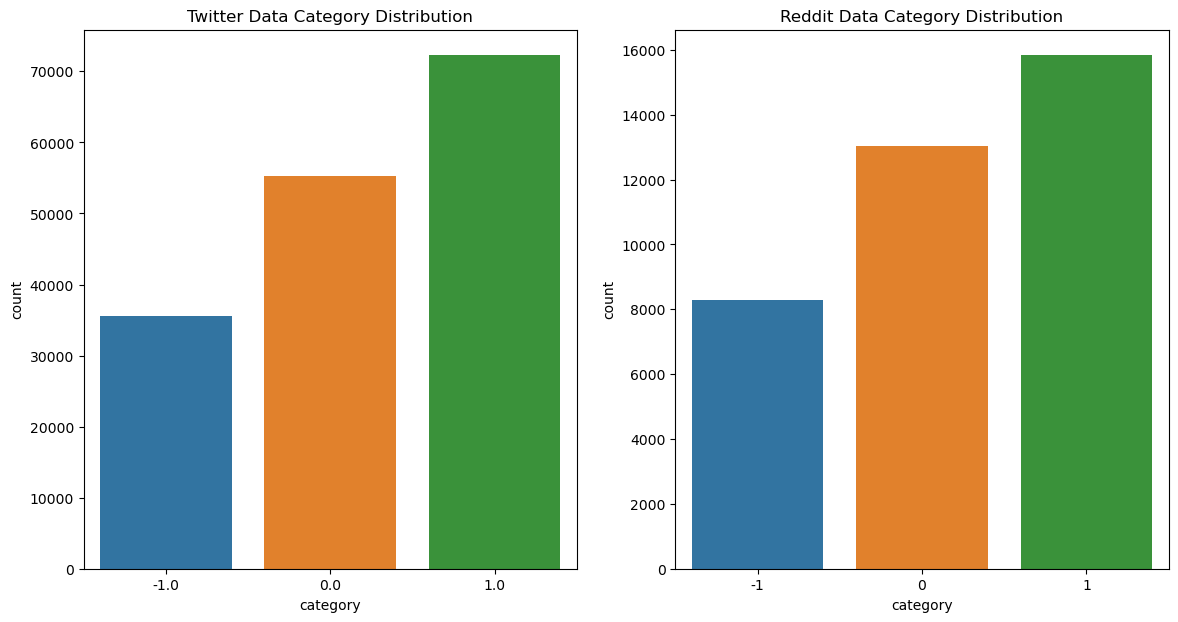

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükle
reddit_data = pd.read_csv('./Reddit_Data.csv')
twitter_data = pd.read_csv('./Twitter_Data.csv')

# Boş değerler varsa temizle
reddit_data.dropna(inplace=True)
twitter_data.dropna(inplace=True)

# Kategorik değişkenlerin dağılımını görselleştirme
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

sns.countplot(x='category', data=twitter_data, ax=axs[0])
axs[0].set_title('Twitter Data Category Distribution')
sns.countplot(x='category', data=reddit_data, ax=axs[1])
axs[1].set_title('Reddit Data Category Distribution')

plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


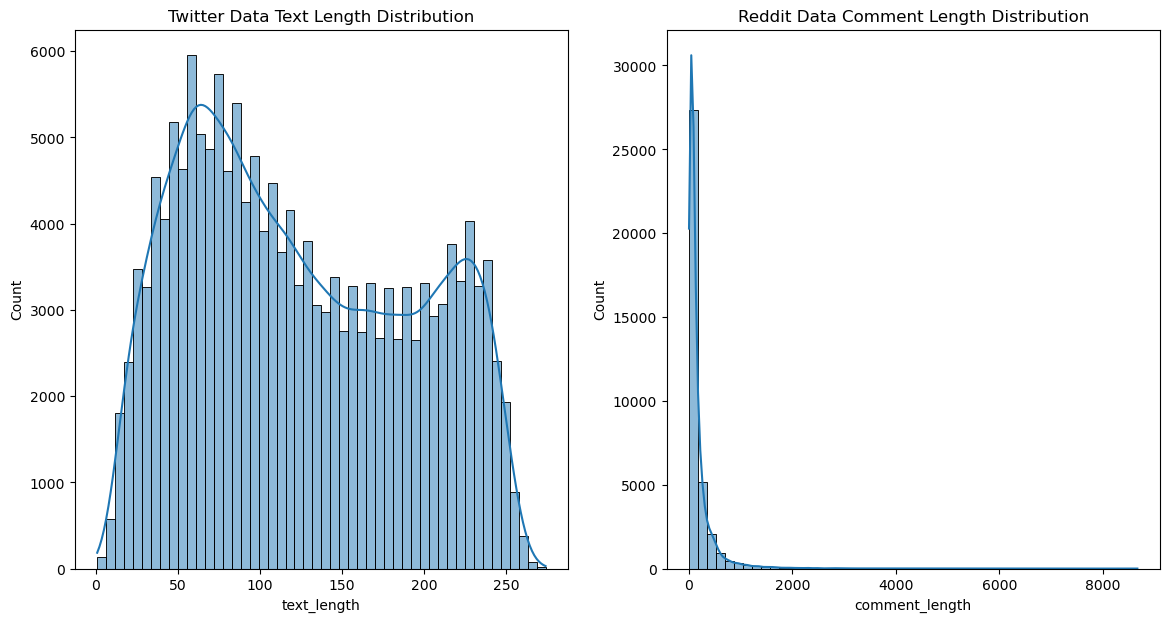

In [7]:
# Yorum uzunluklarını hesapla
twitter_data['text_length'] = twitter_data['clean_text'].apply(len)
reddit_data['comment_length'] = reddit_data['clean_comment'].apply(len)

# Yorum uzunluklarının histogramını çiz
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

sns.histplot(twitter_data['text_length'], bins=50, kde=True, ax=axs[0])
axs[0].set_title('Twitter Data Text Length Distribution')
sns.histplot(reddit_data['comment_length'], bins=50, kde=True, ax=axs[1])
axs[1].set_title('Reddit Data Comment Length Distribution')

plt.show()